In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,f1_score

In [2]:
def split(data, test_data, drop):
    X_train = data.copy()
    y_train = X_train.pop('target')
    X_test = test_data.copy()
    y_test = X_test.pop('target')

    X_train = X_train[y_train != drop]
    X_test = X_test[y_test != drop]

    y_train = y_train[y_train != drop]
    y_test = y_test[y_test != drop]

    std = StandardScaler()
    std.fit(X_train)
    X_train = pd.DataFrame(std.transform(X_train), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(std.transform(X_test), columns = X_test.columns, index = X_test.index)
    return X_train, y_train, X_test, y_test, std

In [3]:
def train_test(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_test),index=y_test.index)
    return model, y_pred

In [4]:
data = pd.read_csv('dataset/train.csv', index_col='name')
test_data = pd.read_csv('dataset/test.csv', index_col='name')

In [30]:
classes = ['normal', 'fatty', 'cirrhosis']

rfc = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=6, criterion='entropy')

final = {}

for drop in classes:
    X_train, y_train, X_test, y_test, std = split(data, test_data, drop)
    cls = np.unique(y_train)
    model, y_pred = train_test(rfc, X_train, y_train, X_test, y_test)
    results = pd.Series(rfc.feature_importances_ , index = X_train.columns).sort_values(ascending=False)
    final[f"{cls[0]}_{cls[1]}"]=results
    results.to_csv(f"dataset/rf selection/{cls[0]}_{cls[1]}.csv")
    report = classification_report(y_test, y_pred, output_dict = True)

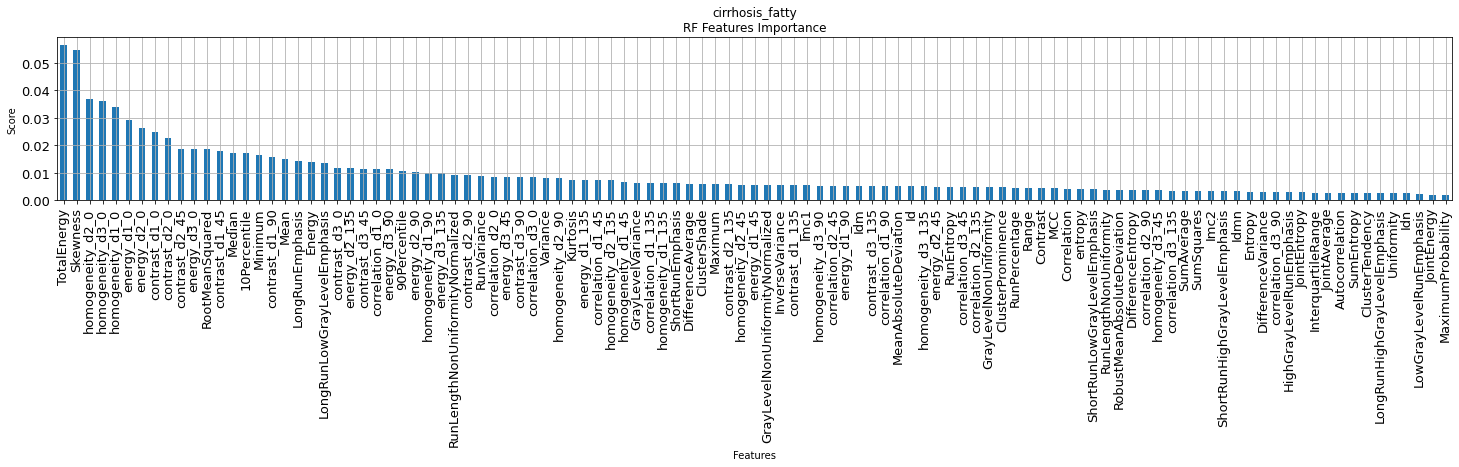

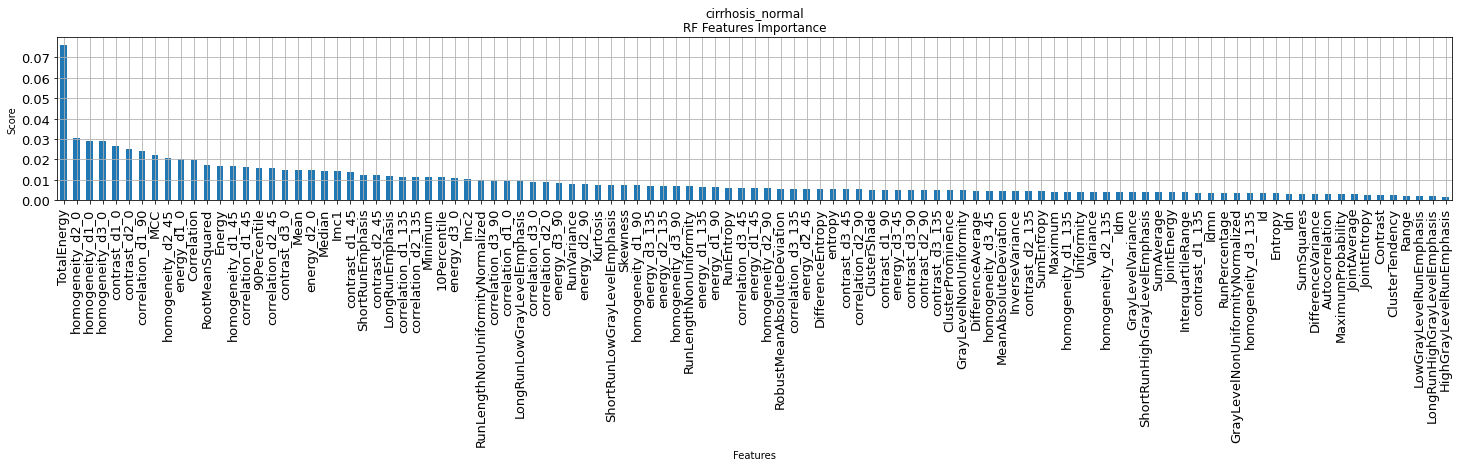

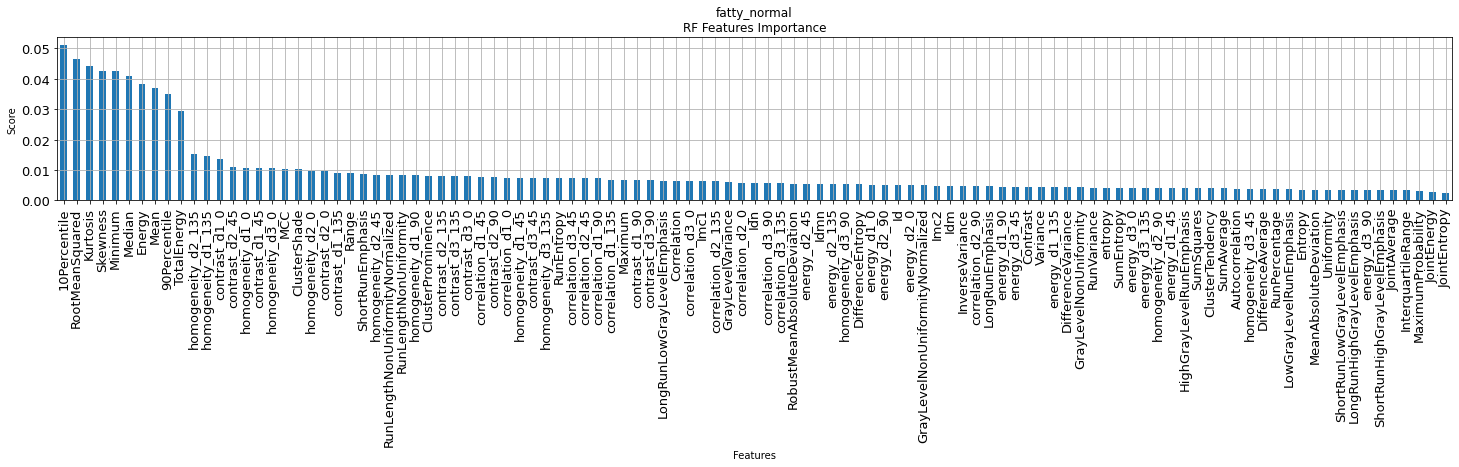

In [32]:
for name in final.keys():
    final[name].plot(title=f'{name}\nRF Features Importance',xlabel='Features',ylabel="Score",kind="bar", legend=False, figsize=(25,3), fontsize=13, grid=True)
    plt.show()

In [37]:
%%time
models = {
    "Random Forest": RandomForestClassifier(
                    random_state=42,
                    max_features='auto',
                    n_estimators= 500,
                    max_depth=6,
                    criterion='entropy',),
    "ANN": MLPClassifier(
                    max_iter=600,
                    momentum=0.6,
                    solver='adam',
                    activation='relu',
                    learning_rate_init=0.005,
                    alpha=0.001,
                    random_state=42),
    "SVM": svm.SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
                    random_state = 42,
                    criterion = 'entropy',
                    max_depth = 2,
                    max_features = 'log2',
                    splitter = 'best',),
    "KNN": KNeighborsClassifier(
                    algorithm='auto',
                    leaf_size=30,
                    metric='minkowski',
                    metric_params=None,
                    n_jobs=10,
                    n_neighbors=2,
                    p=3,
                    weights='uniform'),
}

classes = ['normal', 'fatty', 'cirrhosis']
result = {col:pd.DataFrame() for col in final.keys()}

for classifier in final.keys():
    keep = classifier.split('_')
    drop = [cls for cls in classes if cls not in keep]
    X_train, y_train, X_test, y_test, std = split(data, test_data, drop[0])
    print("Classifier: ", classifier)
    for model_name in models.keys():
        res = pd.DataFrame(columns=[model_name])
        for i in range(2,108):
            cols = final[classifier].index[0:i]
            model, y_pred = train_test(models[model_name], X_train[cols], y_train, X_test[cols], y_test)
            res.loc[i] = {model_name: accuracy_score(y_pred,y_test)}
        print(model_name)
        result[classifier] = pd.concat([result[classifier], res], axis=1)

Classifier:  cirrhosis_fatty
Random Forest
ANN
SVM
Decision Tree
KNN
Classifier:  cirrhosis_normal
Random Forest
ANN
SVM
Decision Tree
KNN
Classifier:  fatty_normal
Random Forest
ANN
SVM
Decision Tree
KNN
Wall time: 15min 10s


In [38]:
for name in result.keys():
    result[name].to_excel(f"dataset/rf selection/model acc/{name}.xlsx")